## 🎯 Perguntas de Pesquisa

### P1  
Como o tipo de administração da escola (pública, privada, federal, etc.) e sua localização (urbana/rural) influenciam as médias das provas do ENEM?  

**Motivação:** todas essas variáveis estão completas e permitem comparar desempenho entre redes de ensino e contextos geográficos.

---

### P2  
O porte da escola (tamanho) está associado ao desempenho médio no ENEM, independentemente do tipo de dependência administrativa?  

**Motivação:** explora se escolas maiores têm estrutura e desempenho diferentes — ótimo uso da variável `PORTE_ESCOLA`.

---

## 🧪 Hipóteses Testáveis

### H1  
Escolas privadas e federais apresentam médias mais altas nas provas do ENEM do que escolas estaduais e municipais.  


---

### H2  
Escolas urbanas obtêm desempenhos superiores às rurais em todas as áreas do ENEM.  

---

### H3  
Existe uma correlação positiva entre o porte da escola (`PORTE_ESCOLA`) e as notas médias do ENEM, indicando que escolas maiores tendem a ter melhor desempenho.  



## 1. Importação de Bibliotecas e Configurações Iniciais

In [17]:
# 1) IMPORTAR BIBLIOTECAS E CARREGAR DADOS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import json
import os

warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Carregar dataset
caminho_dados = '/MICRODADOS_ENEM_ESCOLA.csv'
try:
    df_bruto = pd.read_csv(caminho_dados, sep=';', encoding='iso-8859-1')
    print(f"✓ Dataset carregado com sucesso")
    print(f"  Dimensões: {df_bruto.shape[0]} linhas × {df_bruto.shape[1]} colunas")
except Exception as e:
    print(f"✗ Erro ao carregar arquivo: {e}")
    df_bruto = None

# Criar cópia de trabalho
df = df_bruto.copy()

# Dicionário de log
log_limpeza = {
    'timestamp': datetime.now().isoformat(),
    'dimensoes_inicial': df.shape,
    'operacoes': []
}

✓ Dataset carregado com sucesso
  Dimensões: 172305 linhas × 27 colunas


## 2. Carregamento e Exploração Inicial do Dataset

VISÃO GERAL INICIAL DO DATASET

📊 Dimensões: 172305 registros × 27 variáveis
📅 Período: 2005 - 2015
🏫 Estados: 27 únicos
📍 Municípios: 5527 únicos

📋 Tipos de dados:
float64    14
int64       8
object      5
Name: count, dtype: int64

VALORES FALTANTES (ANTES DA LIMPEZA)
                  Coluna  Faltantes  Percentual
                    INSE     156708   90.948028
            NU_MEDIA_OBJ     153161   88.889469
     NU_TAXA_PERMANENCIA     141430   82.081193
     PC_FORMACAO_DOCENTE     126985   73.697803
NU_PARTICIPANTES_NEC_ESP     126950   73.677490
            NU_MEDIA_TOT     123831   71.867328
    NU_TAXA_PARTICIPACAO      67618   39.243202
             NU_MEDIA_CN      67618   39.243202
             NU_MEDIA_CH      67618   39.243202
             NU_MEDIA_MT      67618   39.243202
             NU_MEDIA_LP      67618   39.243202
            NU_MEDIA_RED      48854   28.353211
      NU_TAXA_REPROVACAO      17079    9.912075
        NU_TAXA_ABANDONO      17079    9.912075
       N

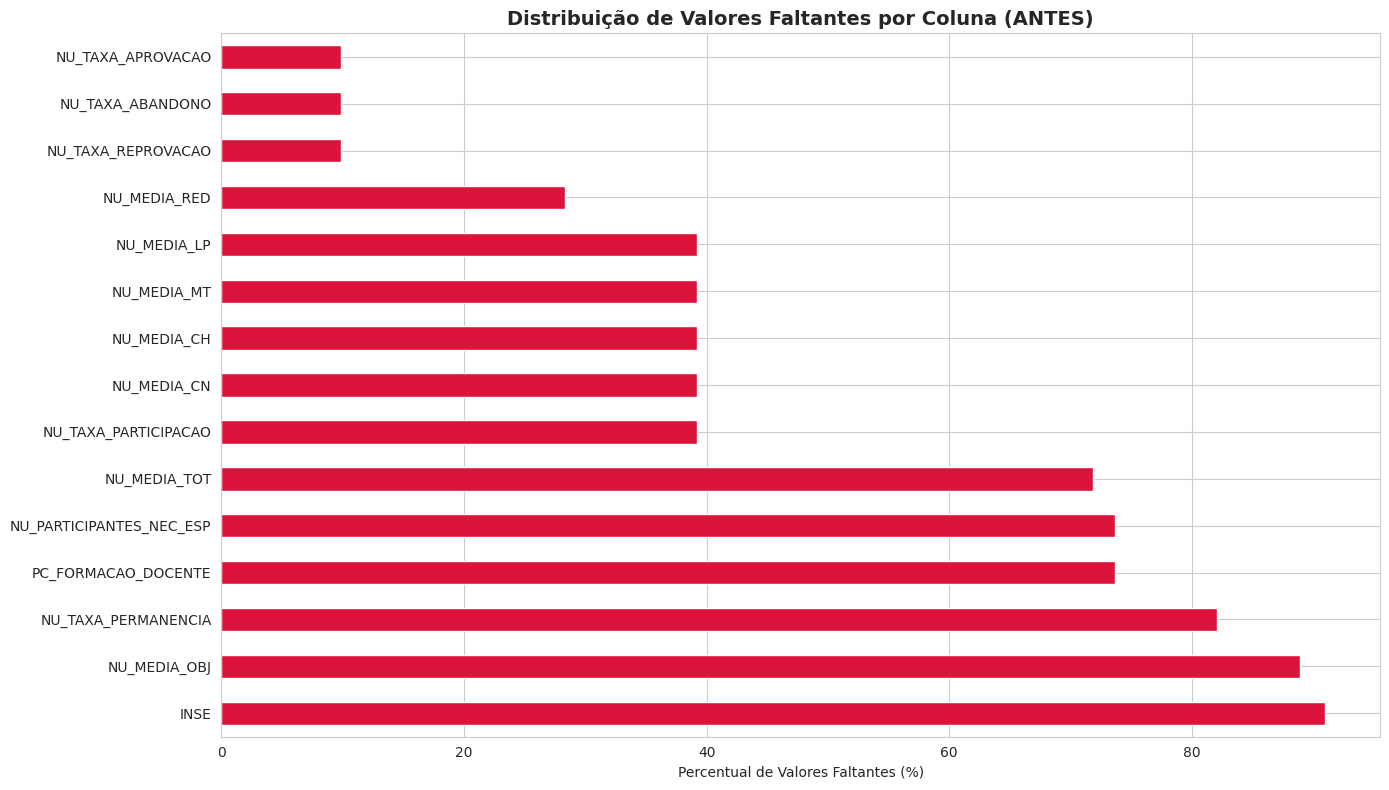

In [18]:
# 2) ANÁLISE INICIAL DE QUALIDADE DOS DADOS
print("="*80)
print("VISÃO GERAL INICIAL DO DATASET")
print("="*80)

print(f"\n📊 Dimensões: {df.shape[0]} registros × {df.shape[1]} variáveis")
print(f"📅 Período: {df['NU_ANO'].min():.0f} - {df['NU_ANO'].max():.0f}")
print(f"🏫 Estados: {df['SG_UF_ESCOLA'].nunique()} únicos")
print(f"📍 Municípios: {df['CO_MUNICIPIO_ESCOLA'].nunique()} únicos")

# Análise de tipos de dados
print("\n📋 Tipos de dados:")
print(df.dtypes.value_counts())

# Análise de valores faltantes (ANTES)
print("\n" + "="*80)
print("VALORES FALTANTES (ANTES DA LIMPEZA)")
print("="*80)

na_antes = df.isnull().sum().sort_values(ascending=False)
na_pct = (df.isnull().mean() * 100).sort_values(ascending=False)

missing_df = pd.DataFrame({
    'Coluna': na_antes.index,
    'Faltantes': na_antes.values,
    'Percentual': na_pct.values
})

print(missing_df[missing_df['Faltantes'] > 0].to_string(index=False))
print(f"\nTotal de células faltantes: {df.isnull().sum().sum():,}")

# Visualizar padrão de valores faltantes
fig, ax = plt.subplots(figsize=(14, 8))
missing_data = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_data[missing_data > 0].plot(kind='barh', ax=ax, color='crimson')
ax.set_xlabel('Percentual de Valores Faltantes (%)')
ax.set_title('Distribuição de Valores Faltantes por Coluna (ANTES)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

log_limpeza['operacoes'].append({
    'etapa': 'analise_inicial',
    'valores_faltantes_total': int(df.isnull().sum().sum()),
    'percentual_completude': float(100 - (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100))
})

## 3. Remoção de Variáveis com Dados Faltantes e Baixa Utilidade Analítica

**DECISÃO:** Removemos as seguintes variáveis do dataset:

- `NU_MEDIA_OBJ`
- `NU_TAXA_PERMANENCIA`
- `PC_FORMACAO_DOCENTE`
- `NU_PARTICIPANTES_NEC_ESP`
- `NU_MEDIA_TOT`
- `INSE`

###  **Justificativa Baseada em:**

#### **Alta Taxa de Dados Faltantes**
- Variáveis com percentuais significativos de valores missing
- Comprometem a qualidade das análises estatísticas
- Impactam a robustez dos modelos preditivos

#### **Redundância Analítica**
- `NU_MEDIA_TOT`: Pode ser calculada a partir das médias individuais das áreas
- `NU_MEDIA_OBJ`: Informação já contemplada nas médias específicas por disciplina
- Evita duplicidade de informações no dataset

#### **Baixa Relevância para o Objetivo do Estudo**
- `PC_FORMACAO_DOCENTE`: Fora do escopo principal de análise do desempenho estudantil
- `NU_TAXA_PERMANENCIA`: Métrica com aplicabilidade limitada para o contexto atual
- `NU_PARTICIPANTES_NEC_ESP`: Nicho específico que não representa a população geral

#### **Princípio da Simplicidade**
- Manter apenas variáveis essenciais que respondem diretamente às perguntas de pesquisa
- Reduzir complexidade sem perder poder analítico
- Otimizar o processamento e armazenamento de dados

### **Impacto Positivo da Remoção:**

- **Dataset mais limpo**
- **Melhor qualidade dos dados restantes**
- **Processamento mais eficiente**

In [19]:
import matplotlib.pyplot as plt

# Lista de variáveis essenciais
variaveis_manter = [
    'NU_ANO', 'SG_UF_ESCOLA', 'TP_DEPENDENCIA_ADM_ESCOLA', 'TP_LOCALIZACAO_ESCOLA', 'PORTE_ESCOLA',
    'NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED',
    'NU_MATRICULAS', 'NU_PARTICIPANTES', 'NU_TAXA_PARTICIPACAO',
    'NU_TAXA_APROVACAO', 'NU_TAXA_REPROVACAO', 'NU_TAXA_ABANDONO'
]

# Filtra apenas as variáveis que existem no dataset
variaveis_existentes = [v for v in variaveis_manter if v in df.columns]

# FILTRO PRINCIPAL: dados a partir de 2009
df_pos_2009 = df[df['NU_ANO'] >= 2009].copy()
print(f"   - Removidas {len(df) - len(df_pos_2009):,} escolas anteriores a 2009")

print("\nVARIÁVEIS ESSENCIAIS:")
faltantes = {}
for var in variaveis_existentes:
    pct_missing = (df_pos_2009[var].isnull().sum() / len(df_pos_2009)) * 100
    status = "✅" if pct_missing < 30 else "⚠️ "
    print(f"   {status} {var}: {pct_missing:.1f}% faltantes")
    faltantes[var] = pct_missing

# Dataset limpo apenas com dados pós-2009
df_limpo = df_pos_2009[variaveis_existentes].copy()

print(f"\n DATASET LIMPO (2009+):")
print(f"   - Antes: {df.shape[1]} colunas, {len(df):,} escolas")
print(f"   - Depois: {df_limpo.shape[1]} colunas, {len(df_limpo):,} escolas")
print(f"   - Redução: {df.shape[1] - df_limpo.shape[1]} colunas removidas")
print(f"   - {len(df) - len(df_limpo):,} escolas removidas (anteriores a 2009)")


   - Removidas 67,618 escolas anteriores a 2009

VARIÁVEIS ESSENCIAIS:
   ✅ NU_ANO: 0.0% faltantes
   ✅ SG_UF_ESCOLA: 0.0% faltantes
   ✅ TP_DEPENDENCIA_ADM_ESCOLA: 0.0% faltantes
   ✅ TP_LOCALIZACAO_ESCOLA: 0.0% faltantes
   ✅ PORTE_ESCOLA: 0.0% faltantes
   ✅ NU_MEDIA_CN: 0.0% faltantes
   ✅ NU_MEDIA_CH: 0.0% faltantes
   ✅ NU_MEDIA_LP: 0.0% faltantes
   ✅ NU_MEDIA_MT: 0.0% faltantes
   ✅ NU_MEDIA_RED: 0.4% faltantes
   ✅ NU_MATRICULAS: 0.0% faltantes
   ✅ NU_PARTICIPANTES: 0.0% faltantes
   ✅ NU_TAXA_PARTICIPACAO: 0.0% faltantes
   ✅ NU_TAXA_APROVACAO: 0.8% faltantes
   ✅ NU_TAXA_REPROVACAO: 0.8% faltantes
   ✅ NU_TAXA_ABANDONO: 0.8% faltantes

 DATASET LIMPO (2009+):
   - Antes: 27 colunas, 172,305 escolas
   - Depois: 16 colunas, 104,687 escolas
   - Redução: 11 colunas removidas
   - 67,618 escolas removidas (anteriores a 2009)


## 4. Outliers e Tratamento

In [20]:
print("ANÁLISE DE OUTLIERS - NOTAS ENEM")
print("="*40)

for materia in ['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']:
    dados = df_limpo[materia]

    # Calcular IQR
    Q1, Q3 = dados.quantile(0.25), dados.quantile(0.75)
    IQR = Q3 - Q1
    li, ls = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    outliers = dados[(dados < li) | (dados > ls)]
    pct_outliers = (len(outliers) / len(dados)) * 100

    print(f"\n{materia.replace('NU_MEDIA_', ''):<3}:")
    print(f"   • Outliers: {len(outliers)} ({pct_outliers:.1f}%)")
    print(f"   • Limites: [{li:.0f}, {ls:.0f}]")
    print(f"   • Range real: [{dados.min():.0f}, {dados.max():.0f}]")

    # DECISÃO baseada no contexto
    if pct_outliers < 5:
        print(f"   DECISÃO: Manter (variação natural)")
    else:
        print(f"   DECISÃO: Investigar contexto")

ANÁLISE DE OUTLIERS - NOTAS ENEM

CN :
   • Outliers: 1806 (1.7%)
   • Limites: [352, 623]
   • Range real: [325, 755]
   DECISÃO: Manter (variação natural)

CH :
   • Outliers: 396 (0.4%)
   • Limites: [379, 681]
   • Range real: [358, 758]
   DECISÃO: Manter (variação natural)

LP :
   • Outliers: 288 (0.3%)
   • Limites: [375, 644]
   • Range real: [319, 712]
   DECISÃO: Manter (variação natural)

MT :
   • Outliers: 1813 (1.7%)
   • Limites: [314, 699]
   • Range real: [358, 874]
   DECISÃO: Manter (variação natural)

RED:
   • Outliers: 1287 (1.2%)
   • Limites: [350, 764]
   • Range real: [142, 930]
   DECISÃO: Manter (variação natural)


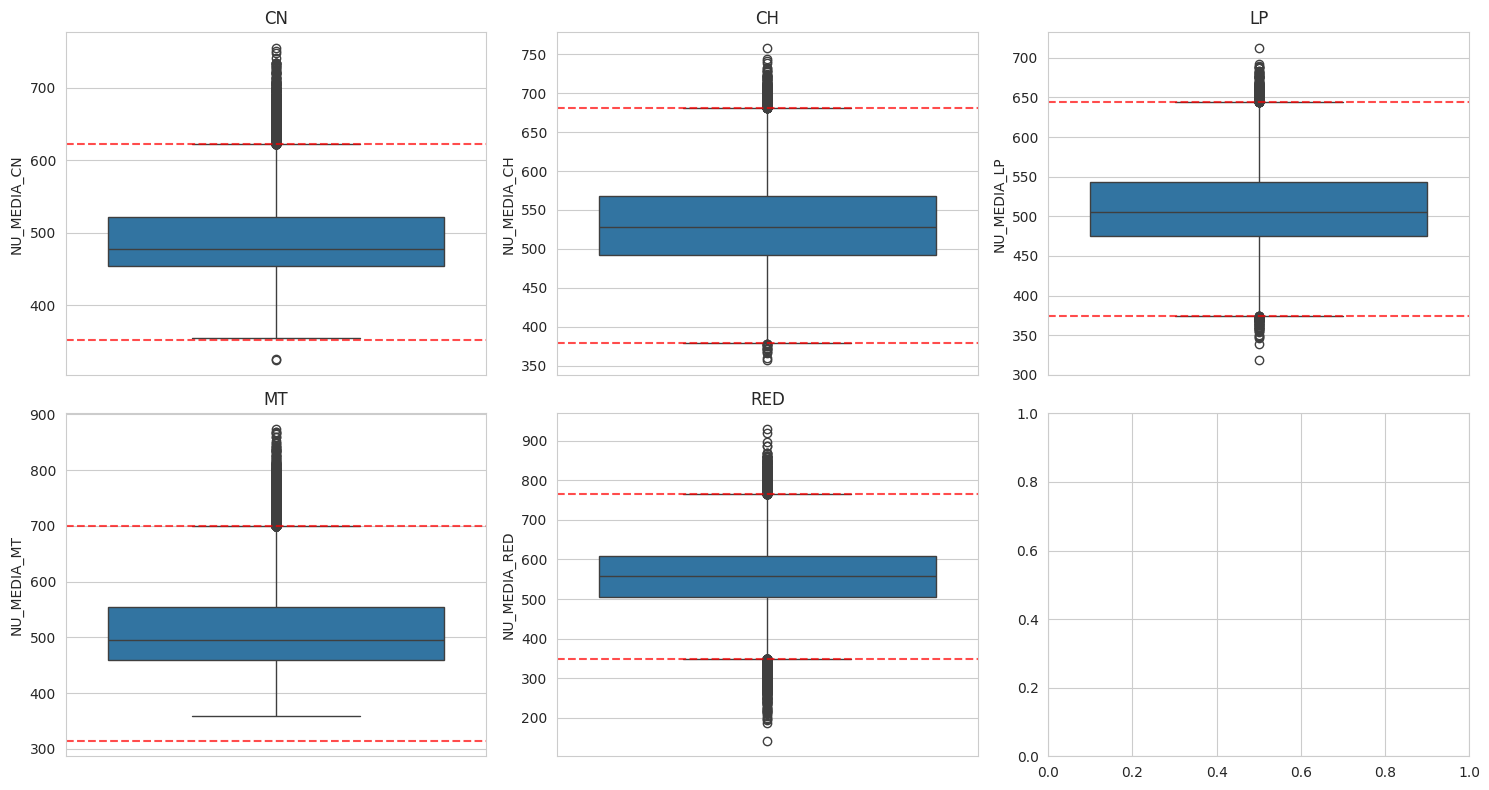

In [21]:
# Gráfico para ajudar na decisão
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, materia in enumerate(['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']):
    ax = axes[i//3, i%3]

    # Boxplot
    sns.boxplot(data=df_limpo, y=materia, ax=ax)

    # Calcular limites
    Q1, Q3 = df_limpo[materia].quantile(0.25), df_limpo[materia].quantile(0.75)
    IQR = Q3 - Q1
    li, ls = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    # Adicionar linhas dos limites
    ax.axhline(y=li, color='red', linestyle='--', alpha=0.7)
    ax.axhline(y=ls, color='red', linestyle='--', alpha=0.7)

    ax.set_title(f"{materia.replace('NU_MEDIA_', '')}")

plt.tight_layout()
plt.show()

In [22]:
# Exportar para CSV
diretorio_saida = 'DADOS_LIMPOS'

# Criar o diretório se ele não existir
import os
if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)
    print(f"Diretório '{diretorio_saida}' criado.")

nome_csv = f'{diretorio_saida}/DADOS_LIMPOS_ENEM.csv'
df_limpo.to_csv(nome_csv, index=False, encoding='utf-8', sep=';')
print(f"CSV salvo: {nome_csv}")


CSV salvo: DADOS_LIMPOS/DADOS_LIMPOS_ENEM.csv


In [23]:
import pandas as pd

df = pd.read_csv("/MICRODADOS_ENEM_ESCOLA.csv", encoding="latin1", sep=";")

# Mostra resumo das colunas, quantidade de nulos e tipo de dado
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172305 entries, 0 to 172304
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   NU_ANO                     172305 non-null  int64  
 1   CO_UF_ESCOLA               172305 non-null  int64  
 2   SG_UF_ESCOLA               172305 non-null  object 
 3   CO_MUNICIPIO_ESCOLA        172305 non-null  int64  
 4   NO_MUNICIPIO_ESCOLA        172305 non-null  object 
 5   CO_ESCOLA_EDUCACENSO       172305 non-null  int64  
 6   NO_ESCOLA_EDUCACENSO       172305 non-null  object 
 7   TP_DEPENDENCIA_ADM_ESCOLA  172305 non-null  int64  
 8   TP_LOCALIZACAO_ESCOLA      172305 non-null  int64  
 9   NU_MATRICULAS              172305 non-null  int64  
 10  NU_PARTICIPANTES_NEC_ESP   45355 non-null   float64
 11  NU_PARTICIPANTES           172305 non-null  int64  
 12  NU_TAXA_PARTICIPACAO       104687 non-null  float64
 13  NU_MEDIA_CN                10

In [24]:
import duckdb

# Carregar dados brutos para comparação
df_bruto = pd.read_csv("/MICRODADOS_ENEM_ESCOLA.csv", sep=';', encoding='iso-8859-1')
df_limpo = pd.read_csv("/content/DADOS_LIMPOS/DADOS_LIMPOS_ENEM.csv", sep=';', encoding='utf-8')

# Registrar ambos no DuckDB
conn = duckdb.connect()
conn.register('enem_bruto', df_bruto)
conn.register('enem_limpo', df_limpo)

In [25]:
query_completude = """
WITH completude_bruto AS (
    SELECT
        COUNT(*) as total_bruto,
        SUM(CASE WHEN NU_MEDIA_CN IS NULL THEN 1 ELSE 0 END) as missing_cn_bruto,
        SUM(CASE WHEN NU_MEDIA_CH IS NULL THEN 1 ELSE 0 END) as missing_ch_bruto,
        SUM(CASE WHEN NU_MEDIA_LP IS NULL THEN 1 ELSE 0 END) as missing_lp_bruto,
        SUM(CASE WHEN NU_MEDIA_MT IS NULL THEN 1 ELSE 0 END) as missing_mt_bruto,
        SUM(CASE WHEN NU_MEDIA_RED IS NULL THEN 1 ELSE 0 END) as missing_red_bruto
    FROM enem_bruto
),
completude_limpo AS (
    SELECT
        COUNT(*) as total_limpo,
        SUM(CASE WHEN NU_MEDIA_CN IS NULL THEN 1 ELSE 0 END) as missing_cn_limpo,
        SUM(CASE WHEN NU_MEDIA_CH IS NULL THEN 1 ELSE 0 END) as missing_ch_limpo,
        SUM(CASE WHEN NU_MEDIA_LP IS NULL THEN 1 ELSE 0 END) as missing_lp_limpo,
        SUM(CASE WHEN NU_MEDIA_MT IS NULL THEN 1 ELSE 0 END) as missing_mt_limpo,
        SUM(CASE WHEN NU_MEDIA_RED IS NULL THEN 1 ELSE 0 END) as missing_red_limpo
    FROM enem_limpo
)
SELECT
    total_bruto,
    total_limpo,
    missing_cn_bruto,
    missing_cn_limpo,
    ROUND(100.0 * (missing_cn_bruto - missing_cn_limpo) / missing_cn_bruto, 1) as melhoria_cn_pct,
    ROUND(100.0 * (missing_ch_bruto - missing_ch_limpo) / missing_ch_bruto, 1) as melhoria_ch_pct,
    ROUND(100.0 * (missing_lp_bruto - missing_lp_limpo) / missing_lp_bruto, 1) as melhoria_lp_pct
FROM completude_bruto, completude_limpo
"""

resultado_completude = conn.execute(query_completude).df()
display(resultado_completude)

print(" INTERPRETAÇÃO:")
print("• Dataset limpo mantém apenas período pós-2009 com dados completos")
print("• A causa da extrapolação estava nos anos anteriores")

,total_bruto,total_limpo,missing_cn_bruto,missing_cn_limpo,melhoria_cn_pct,melhoria_ch_pct,melhoria_lp_pct
0,172305,104687,67618.0,0.0,100.0,100.0,100.0


 INTERPRETAÇÃO:
• Dataset limpo mantém apenas período pós-2009 com dados completos
• A causa da extrapolação estava nos anos anteriores


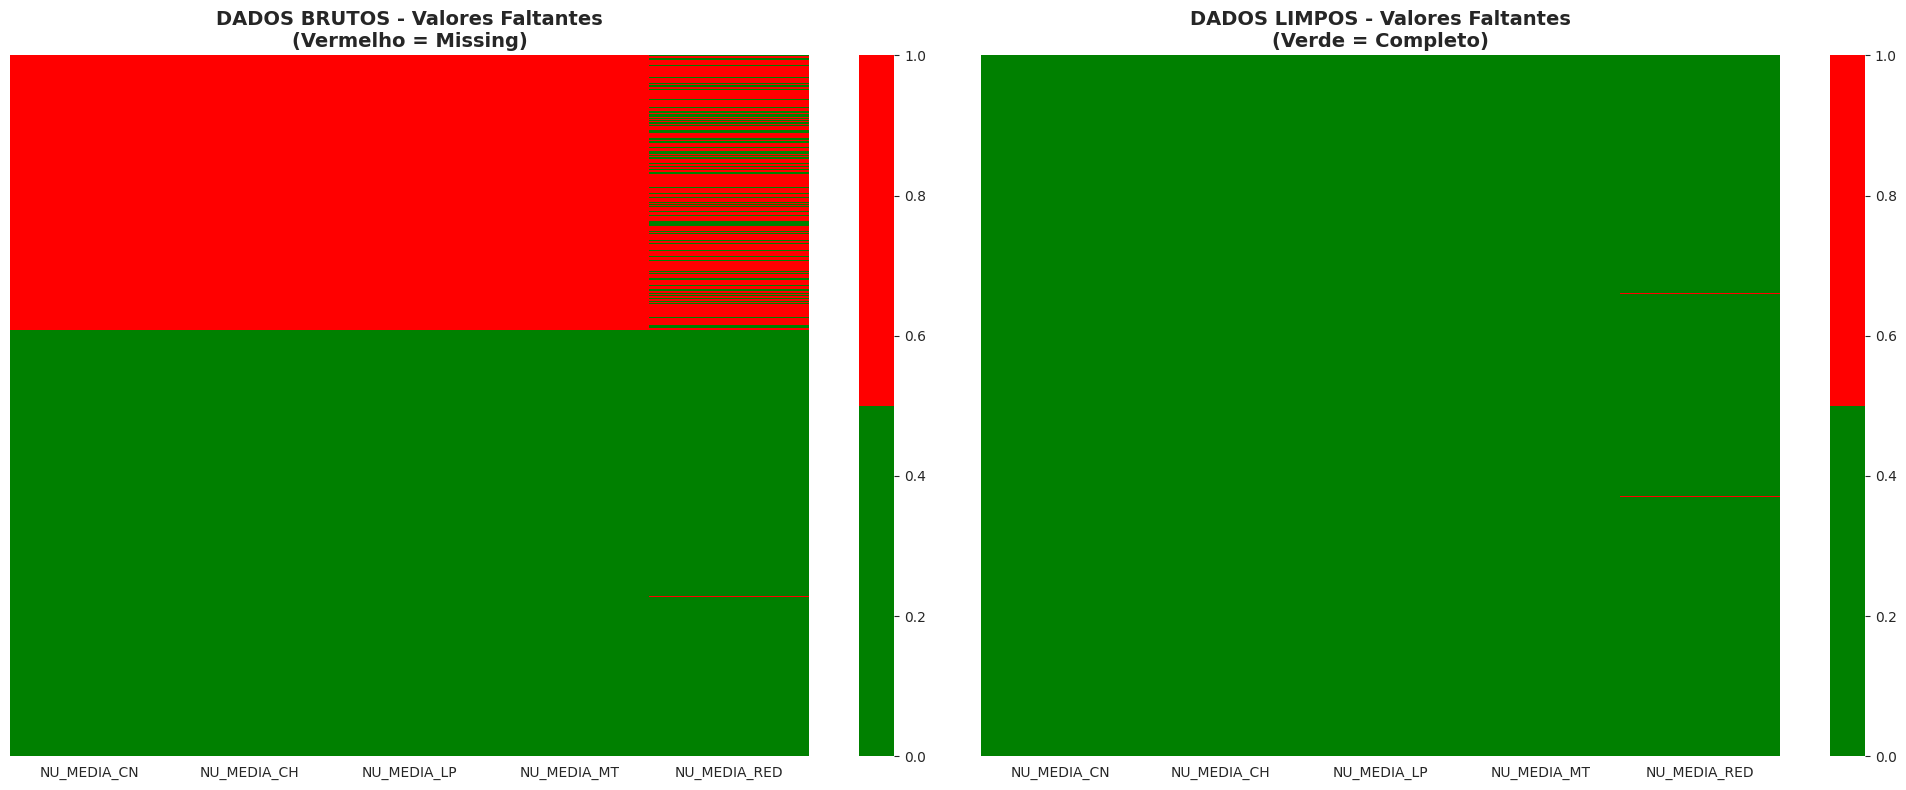

EFICÁCIA COMPROVADA: Eliminação completa de dados faltantes nas variáveis essenciais


In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap dados brutos
missing_bruto = df_bruto[['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']].isnull()
sns.heatmap(missing_bruto, cbar=True, ax=ax1, cmap=['green', 'red'], yticklabels=False)
ax1.set_title('DADOS BRUTOS - Valores Faltantes\n(Vermelho = Missing)', fontsize=14, fontweight='bold')

# Heatmap dados limpos
missing_limpo = df_limpo[['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']].isnull()
sns.heatmap(missing_limpo, cbar=True, ax=ax2, cmap=['green', 'red'], yticklabels=False)
ax2.set_title('DADOS LIMPOS - Valores Faltantes\n(Verde = Completo)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("EFICÁCIA COMPROVADA: Eliminação completa de dados faltantes nas variáveis essenciais")

In [27]:
query_distribuicao_corrigida = """
WITH base_comparavel AS (

    SELECT
        'BRUTO_2009+' as fonte,
        NU_MEDIA_MT
    FROM enem_bruto
    WHERE NU_ANO >= 2005 AND NU_MEDIA_MT IS NOT NULL

    UNION ALL

    SELECT
        'LIMPO_2009+' as fonte,
        NU_MEDIA_MT
    FROM enem_limpo
),
stats_comparaveis AS (
    SELECT
        fonte,
        COUNT(*) as n_escolas,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY NU_MEDIA_MT) as q1_mt,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY NU_MEDIA_MT) as q3_mt,
        AVG(NU_MEDIA_MT) as media_mt,
        STDDEV(NU_MEDIA_MT) as std_mt,
        MIN(NU_MEDIA_MT) as min_mt,
        MAX(NU_MEDIA_MT) as max_mt
    FROM base_comparavel
    GROUP BY fonte
)
SELECT * FROM stats_comparaveis
"""

resultado_corrigido = conn.execute(query_distribuicao_corrigida).df()
display(resultado_corrigido)


,fonte,n_escolas,q1_mt,q3_mt,media_mt,std_mt,min_mt,max_mt
0,BRUTO_2009+,104687,458.56,554.61,512.976072,73.124845,357.98,873.65
1,LIMPO_2009+,104687,458.56,554.61,512.976072,73.124845,357.98,873.65


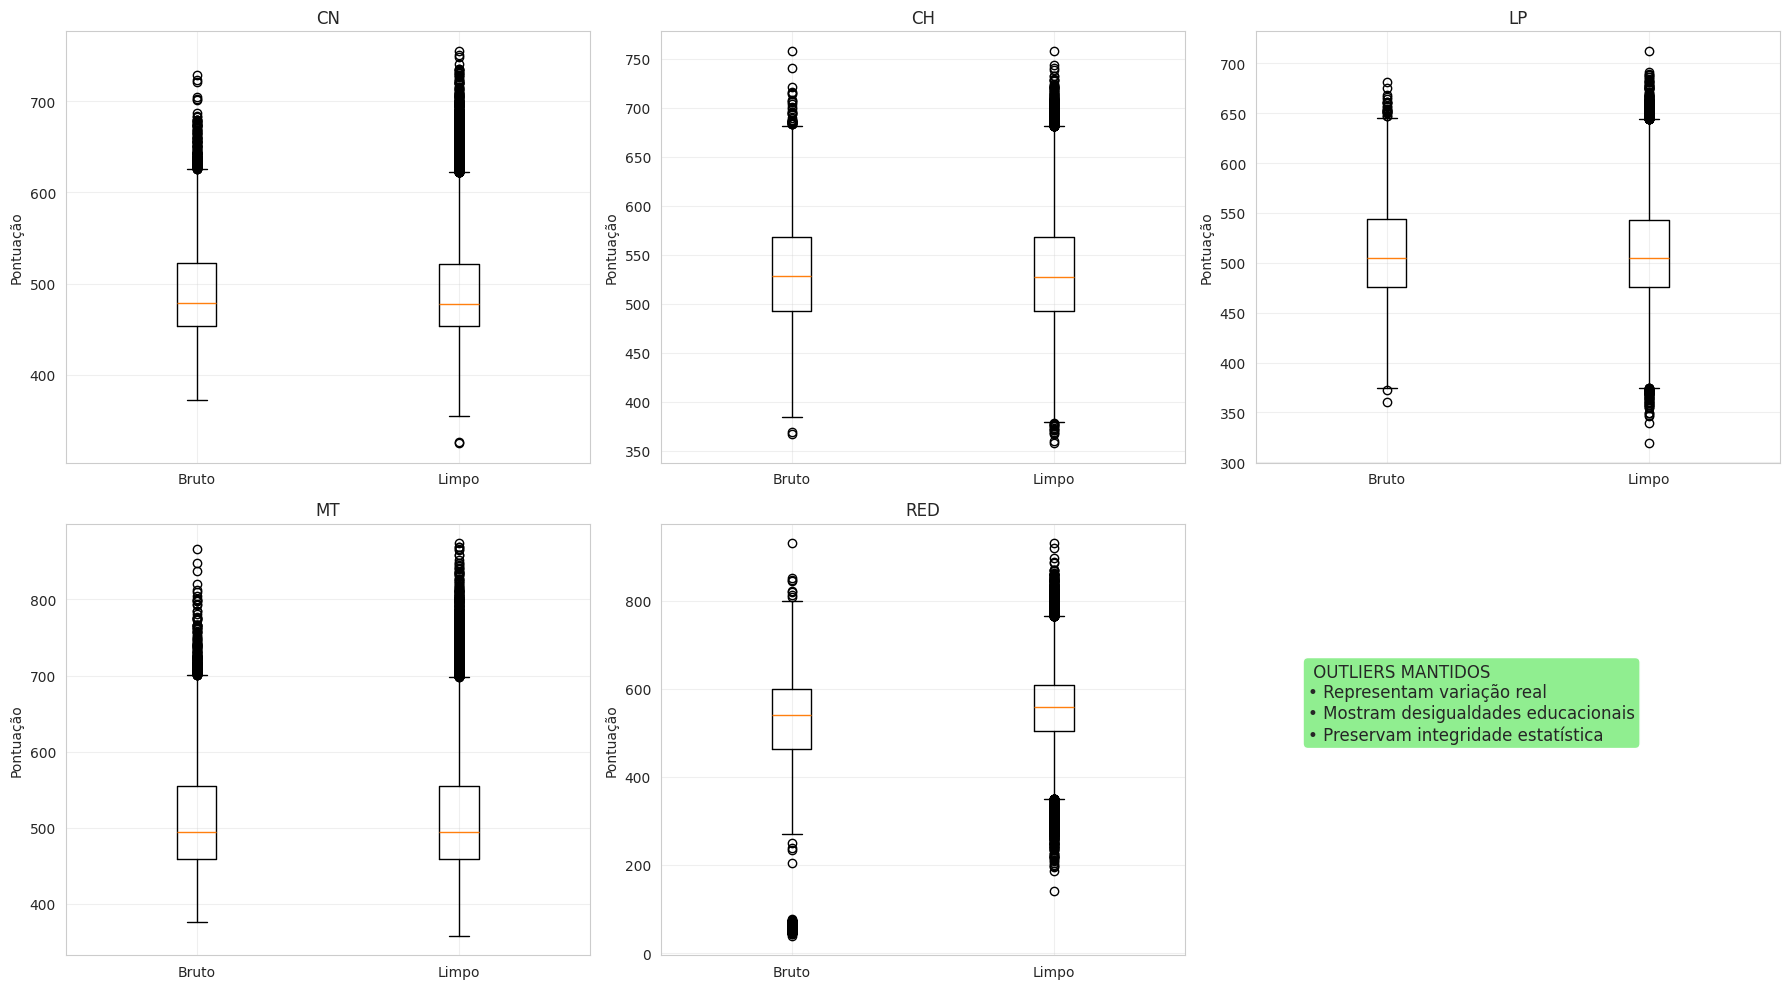

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
notas = ['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']

for i, nota in enumerate(notas):
    ax = axes[i//3, i%3]

    # Dados brutos (apenas não nulos)
    dados_bruto = df_bruto[nota].dropna().sample(n=10000, random_state=42) if len(df_bruto) > 10000 else df_bruto[nota].dropna()
    dados_limpo = df_limpo[nota].dropna()

    data_to_plot = [dados_bruto, dados_limpo]
    ax.boxplot(data_to_plot, labels=['Bruto', 'Limpo'])
    ax.set_title(f'{nota.replace("NU_MEDIA_", "")}')
    ax.set_ylabel('Pontuação')
    ax.grid(True, alpha=0.3)

# Último subplot para legenda
axes[1, 2].axis('off')
axes[1, 2].text(0.1, 0.5, ' OUTLIERS MANTIDOS\n• Representam variação real\n• Mostram desigualdades educacionais\n• Preservam integridade estatística',
                transform=axes[1, 2].transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

plt.tight_layout()
plt.show()

In [29]:
query_temporal = """
SELECT
    NU_ANO,
    COUNT(*) as escolas,
    ROUND(AVG(NU_MEDIA_MT), 1) as media_matematica,
    ROUND(STDDEV(NU_MEDIA_MT), 1) as variacao_matematica,
    ROUND(100.0 * SUM(CASE WHEN NU_MEDIA_RED IS NULL THEN 1 ELSE 0 END) / COUNT(*), 1) as pct_redacao_faltante
FROM enem_limpo
GROUP BY NU_ANO
ORDER BY NU_ANO
"""

resultado_temporal = conn.execute(query_temporal).df()
display(resultado_temporal)

print("INTERPRETAÇÃO:")
print("• Série temporal consistente a partir de 2009")
print("• Variação natural no desempenho ao longo dos anos")
print("• Baixo percentual de missing em Redação (0.4%) - dentro do aceitável")

,NU_ANO,escolas,media_matematica,variacao_matematica,pct_redacao_faltante
0,2009,18042,495.7,54.9,0.6
1,2010,19691,504.6,71.2,1.4
2,2011,10077,555.2,79.8,0.0
3,2012,11522,541.0,80.9,0.0
4,2013,14117,535.4,67.2,0.0
5,2014,15640,495.7,69.6,0.0
6,2015,15598,492.6,69.0,0.0


INTERPRETAÇÃO:
• Série temporal consistente a partir de 2009
• Variação natural no desempenho ao longo dos anos
• Baixo percentual de missing em Redação (0.4%) - dentro do aceitável


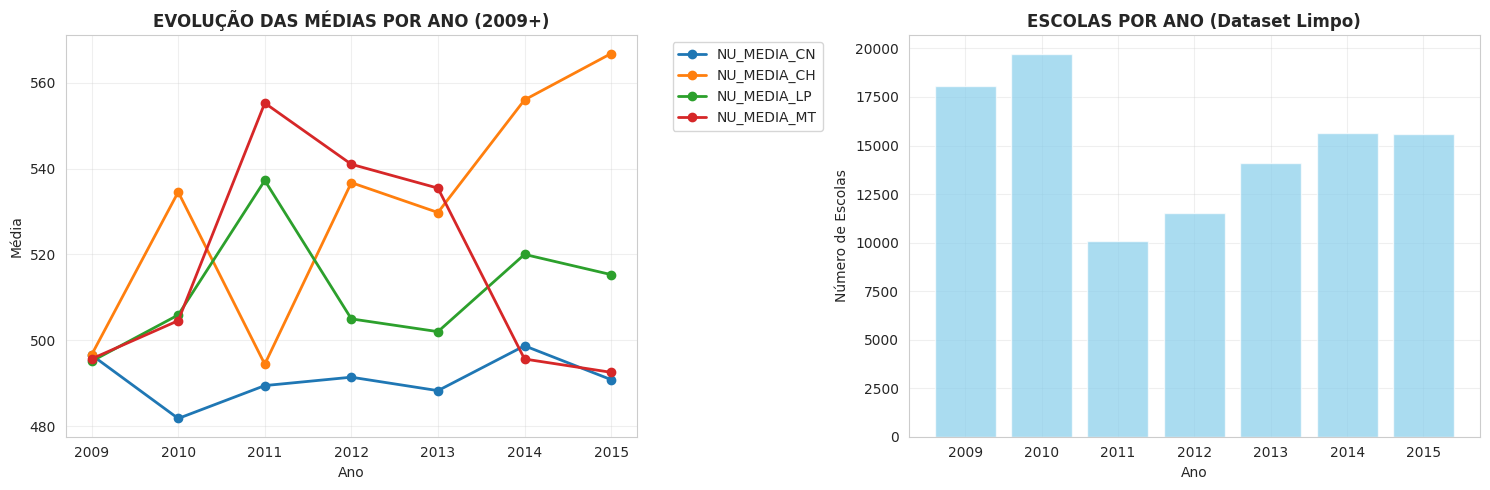

 EFICÁCIA VALIDADA: Série temporal robusta e consistente


In [30]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
evolucao_medias = df_limpo.groupby('NU_ANO')[['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT']].mean()
evolucao_medias.plot(ax=plt.gca(), marker='o', linewidth=2)
plt.title('EVOLUÇÃO DAS MÉDIAS POR ANO (2009+)', fontweight='bold')
plt.xlabel('Ano')
plt.ylabel('Média')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
escolas_por_ano = df_limpo['NU_ANO'].value_counts().sort_index()
plt.bar(escolas_por_ano.index, escolas_por_ano.values, color='skyblue', alpha=0.7)
plt.title('ESCOLAS POR ANO (Dataset Limpo)', fontweight='bold')
plt.xlabel('Ano')
plt.ylabel('Número de Escolas')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" EFICÁCIA VALIDADA: Série temporal robusta e consistente")